<a href="https://colab.research.google.com/github/jang-jin/mini_project1_news_title_generator/blob/master/modeling/BiLSTM_with_Attention%2Bkonlpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/AI-school/로테이션 수업 자료/NLP/project

/content/drive/My Drive/Colab Notebooks/AI-school/로테이션 수업 자료/NLP/project


# Library import

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 158kB/s 
     |████████████████████████████████| 3.8MB 57.2MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from konlpy.tag import Hannanum, Kkma, Komoran, Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Concatenate, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data preprocess

In [ ]:
news_dataset = pd.read_csv("./news_dataset.csv")
print(news_dataset.shape)
news_dataset.head()

(27322, 2)


,title,article
0,미국 최초로 GM 모기 살포 실험,"미국 남부, 플로리다 주에 길이 약 240km의 산호초 군도가 있다. 플로리다키스 ..."
1,공룡도 척추 디스크로 고생했다,척추 디스크는 현대인에게서 가장 많이 발생하는 질환 중 하나다. 국민건강보험공단 등...
2,투명 고분자 물질 레이저로 초고속 가공하는 기술 개발,한국연구재단은 서울대 고승환·전누리 교수 연구팀이 투명 물질인 ‘폴리디메틸실록산'(...
3,"기초지원연, 물속 중금속 흡착 철산화물 나노입자 섬유 개발",한국기초과학지원연구원은 박종배 박사 연구팀이 물속 중금속을 흡착할 수 있는 철산화물...
4,"산업부, 중기 개발한 소재부품장비 양산 위한 성능평가 지원",산업통상자원부는 ‘2020년도 소재·부품·장비(소부장) 양산 성능평가 지원사업’을 ...


In [ ]:
news_dataset = news_dataset.sample(frac=1, random_state=13)

In [ ]:
news_dataset['title'] = news_dataset['title'].str.replace("[^\w]", " ")
news_dataset['article'] = news_dataset['article'].str.replace("[^\w]", " ")
news_dataset['title'] = news_dataset['title'].replace("", np.nan)
news_dataset['article'] = news_dataset['article'].replace("", np.nan)
news_dataset = news_dataset.dropna(how='any')
print(news_dataset.shape)
news_dataset.head()

(27321, 2)


,title,article
23692,Missing People Measure,Families who have lost children or elderly dem...
26700,국내 ICT 기업 연구개발비 40조원 돌파,국내 정보통신기술 ICT 기업의 연구개발비가 40조원을 돌파한 것으로 나타났다 과...
19604,주파수 훔쳐 쓰다간 엉뚱한 대형사고 납니다,얼마전 개봉한 영화 나이트 크롤러 감독 댄 길로이 를 아십니까 직장이 없는 루...
9335,크루 드래건 뭐가 달라졌나,지난달 31일 한국 시각 발사된 스페이스X의 유인 우주선 크루 드래건 이 국제우...
18625,미래부 평창 ICT 동계올림픽 추진 TF 출범,오는 2018년 평창 동계올림픽이 성공적으로 개최되도록 정보통신기술을 개발 지원하는...


In [ ]:
encoder_input, decoder_input, decoder_output = [], [], []
okt = Okt()

for stc in news_dataset['article']:
    encoder_input.append(okt.morphs(stc, stem=True))

# 스타트 뒤에 띄어쓰기
for stc in news_dataset['title']:
    decoder_input.append(["<start>"]+okt.morphs(stc, stem=True))

for stc in news_dataset['title']:
    decoder_output.append(okt.morphs(stc, stem=True)+["<end>"])

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['Families', 'who', 'have', 'lost', 'children', 'or', 'elderly', 'dementia', 'parents', 'suffer', 'from', 'indescribable', 'pain', 'In', 'the', 'case', 'of', 'missing', 'people', 'incidents', 'tracking', 'down', 'their', 'whereabouts', 'in', 'the', 'first', '48', 'hours', 'is', 'crucial', 'in', 'efforts', 'to', 'locate', 'the', 'individuals', 'Korean', 'researchers', 'have', 'joined', 'hands', 'with', 'the', 'police', 'to', 'reduce', 'this', 'golden', 'time', 'window', 'for', 'better', 'chances', 'of', 'finding', 'our', 'loved', 'ones', 'About', '40', 'thousand', 'children', 'and', 'dementia', 'patients', 'go', 'missing', 'every', 'year', 'Luckily', 'in', 'most', 'cases', 'they', 'are', 'reunited', 'with', 'their', 'families', 'Figuring', 'out', 'their', 'travel', 'path', 'is', 'most', 'important', 'in', 'locating', 'missing', 'people', 'Officials', 'must', 'trace', 'the', 'movements', 'of', 'the', 'missing', 'persons', 'during', 'the', 'initial', '48', 'hour', 'period', 'the', 'so', 

In [ ]:
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(encoder_input)
encoder_input = tokenizer_en.texts_to_sequences(encoder_input)

tokenizer_de = Tokenizer()
tokenizer_de.fit_on_texts(decoder_input)
tokenizer_de.fit_on_texts(decoder_output)
decoder_input = tokenizer_de.texts_to_sequences(decoder_input)
decoder_output = tokenizer_de.texts_to_sequences(decoder_output)

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[43952, 2563, 5652, 30352, 16047, 4179, 34120, 18406, 39760, 34121, 4606, 74194, 19750, 1273, 434, 16350, 564, 22864, 7725, 36640, 26341, 11348, 7485, 74195, 1273, 434, 7141, 4396, 18004, 2139, 27570, 1273, 28845, 1196, 30353, 434, 32072, 5914, 10641, 5652, 49574, 34122, 3507, 434, 30354, 1196, 26342, 3618, 19751, 5073, 19239, 2187, 18799, 43953, 564, 27571, 12702, 74196, 32073, 10131, 760, 23613, 16047, 981, 18406, 14123, 5058, 22864, 24441, 7055, 74197, 1273, 11691, 19240, 8106, 3647, 74198, 3507, 7485, 43952, 74199, 7949, 7485, 20804, 30355, 2139, 11691, 20275, 1273, 43954, 22864, 7725, 74200, 22102, 24442, 434, 18407, 564, 434, 22864, 58014, 13026, 434, 27572, 4396, 16638, 14529, 434, 7569, 17278, 19751, 5073, 34123, 23614, 24443, 9981, 58015, 30354, 12461, 21423, 1196, 30353, 434, 22864, 1273, 434, 11568, 16930, 34124, 1196, 49575, 17647, 981, 17648, 5726, 5073, 49576, 20276, 434, 13737, 2139, 16351, 5914, 10641, 5652, 8338, 368, 3155, 49577, 3905, 39761, 3618, 18800, 19239, 564,

In [ ]:
print(f"인코더 데이터 단어 개수 : {len(tokenizer_en.word_index)}")
print(f"디코더 데이터 단어 개수 : {len(tokenizer_de.word_index)}")

인코더 데이터 단어 개수 : 120945
디코더 데이터 단어 개수 : 16977


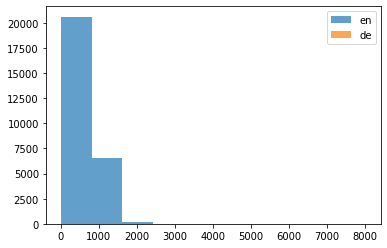

In [ ]:
len_en = list(map(len, encoder_input))
len_de = list(map(len, decoder_input))

plt.hist(len_en, label='en', alpha=0.7)
plt.hist(len_de, label='de', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
print(f"인코더 데이터 길이 평균 : {np.mean(len_en)}")
print(f"디코더 데이터 길이 평균 : {np.mean(len_de)}")
print(f"인코더 데이터 길이 중간값 : {np.median(len_en)}")
print(f"디코더 데이터 길이 중간값 : {np.median(len_de)}")

인코더 데이터 길이 평균 : 508.78053511950515
디코더 데이터 길이 평균 : 9.077998609128509
인코더 데이터 길이 중간값 : 353.0
디코더 데이터 길이 중간값 : 9.0


In [ ]:
# padding="post" : 앞부터 문장, 뒤에 0값을 채우기 위해
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])
print(encoder_input.shape)
print(decoder_input.shape)

[[43952  2563  5652 ...     0     0     0]
 [  136  1764   249 ...     0     0     0]
 [ 1747    47  5338 ...     0     0     0]]
[[    1 10102 10103 10104     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    1    31   163   165   806    49 10105   935     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    1   770  4303   516  6273  1080   395  1135     0     0     0     0
      0     0     0     0     0     0     0     0     0]]
[[10102 10103 10104     2     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [   31   163   165   806    49 10105   935     2     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  770  4303   516  6273  1080   395  1135     2     0     0     0     0
      0     0     0     0     0     0     0     0     0]]
(27321, 8022)
(27321, 21)


In [ ]:
# 나중에 prediction 할 때 사용하기 위함(인덱스로 단어 찾기)
de_to_index = tokenizer_de.word_index
index_to_de = tokenizer_de.index_word

In [ ]:
test_size = 5000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

# Training

In [ ]:
# hyperparameter
word_embedding = 100
LSTM_unit = 64

In [ ]:
encoder_inputs = Input(shape=(encoder_input.shape[1],))
encoder_embed = Embedding(len(tokenizer_en.word_index)+1, word_embedding)(encoder_inputs)
encoder_mask = Masking(mask_value=0)(encoder_embed)
encoder_outputs, forward_h_state, forward_c_state, backward_h_state, backward_c_state = Bidirectional(LSTM(LSTM_unit, return_state=True, return_sequences=True))(encoder_mask)

In [ ]:
decoder_inputs = Input(shape=(decoder_input.shape[1],))
decoder_embed = Embedding(len(tokenizer_de.word_index)+1, word_embedding)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)
decoder_lstm = Bidirectional(LSTM(LSTM_unit, return_sequences=True, return_state=True))
decoder_outputs, _, _, _, _ = decoder_lstm(decoder_mask, initial_state=[forward_h_state, forward_c_state, backward_h_state, backward_c_state])

In [ ]:
from attention import AttentionLayer

attn_layer = AttentionLayer()
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate()([decoder_outputs, attn_out])

decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax')
decoder_softmax_outputs = decoder_dense(decoder_concat_input)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8022)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8022, 100)    12094600    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 100)      1697800     input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_check = ModelCheckpoint('./seq2seq_news_title.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_output_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test),
          batch_size=32, epochs=100,
          callbacks=[early_stop, model_check])

Epoch 1/100
698/698 [==============================] - ETA: 0s - loss: 3.2549 - acc: 0.6183
Epoch 00001: val_acc improved from -inf to 0.63664, saving model to ./seq2seq_news_title.h5
698/698 [==============================] - 851s 1s/step - loss: 3.2549 - acc: 0.6183 - val_loss: 2.7718 - val_acc: 0.6366
Epoch 2/100
698/698 [==============================] - ETA: 0s - loss: 2.5260 - acc: 0.6560
Epoch 00002: val_acc improved from 0.63664 to 0.67435, saving model to ./seq2seq_news_title.h5
698/698 [==============================] - 839s 1s/step - loss: 2.5260 - acc: 0.6560 - val_loss: 2.3958 - val_acc: 0.6744
Epoch 3/100
698/698 [==============================] - ETA: 0s - loss: 2.2555 - acc: 0.6901
Epoch 00003: val_acc improved from 0.67435 to 0.70129, saving model to ./seq2seq_news_title.h5
698/698 [==============================] - 837s 1s/step - loss: 2.2555 - acc: 0.6901 - val_loss: 2.1970 - val_acc: 0.7013
Epoch 4/100
698/698 [==============================] - ETA: 0s - loss: 2.042

# Prediction

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, forward_h_state, forward_c_state, backward_h_state, backward_c_state])

In [ ]:
encoder_forward_h_state = Input(shape=(LSTM_unit,))
encoder_forward_c_state = Input(shape=(LSTM_unit,))
encoder_backward_h_state = Input(shape=(LSTM_unit,))
encoder_backward_c_state = Input(shape=(LSTM_unit,))

pd_decoder_outputs, pd_forward_h_state, pd_forward_c_state, pd_backward_h_state, pd_backward_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_forward_h_state, encoder_forward_c_state, encoder_backward_h_state, encoder_backward_c_state])

# 어텐션
pd_encoder_outputs = Input(shape=(encoder_input.shape[1], LSTM_unit*2))
pd_attn_out, pd_attn_states = attn_layer([pd_encoder_outputs, pd_decoder_outputs])
pd_decoder_concat = Concatenate()([pd_decoder_outputs, pd_attn_out])

pd_decoder_softmax_outputs = decoder_dense(pd_decoder_concat)

decoder_model = Model([decoder_inputs, pd_encoder_outputs, encoder_forward_h_state, encoder_forward_c_state, encoder_backward_h_state, encoder_backward_c_state], [pd_decoder_softmax_outputs, pd_forward_h_state, pd_forward_c_state, pd_backward_h_state, pd_backward_c_state])

In [ ]:
input_stc = input()
preprocess_stc = input_stc.replace("\n"," ").replace(" +", " ").replace("[^\w]","")
token_stc = okt.morphs(preprocess_stc, stem=True)
encode_stc = tokenizer_en.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=encoder_input.shape[1], padding="post")

en_out, for_en_hidden, for_en_cell, back_en_hidden, back_en_cell = encoder_model.predict(pad_stc)

predicted_seq = np.zeros((1,1))
predicted_seq[0,0] = de_to_index["<start>"]

decoded_stc = []

while True:
    output_words, for_h, for_c, back_h, back_c = decoder_model.predict([predicted_seq, en_out, for_en_hidden, for_en_cell, back_en_hidden, back_en_cell])

    predicted_word = index_to_de[np.argmax(output_words[0,0])]

    if predicted_word == "<end>":
        break
    
    decoded_stc.append(predicted_word)
    print(predicted_word)
    predicted_seq = np.zeros((1,1))
    predicted_seq[0,0] = np.argmax(output_words[0,0])

    for_en_hidden = for_h
    for_en_cell = for_c
    back_en_hidden = back_h
    back_en_cell = back_c

print(' '.join(decoded_stc))

과학기술정보통신부는 '전문과학관 건립 사업' 대상 지역 후보지로 강원도와 울산광역시, 전라남도 등 3곳을 선정했다고 오늘(17일) 밝혔습니다.  과기정통부는 이들 후보지 3곳을 대상으로, 현장 조사를 거쳐 최종 건립 대상지를 선정할 예정입니다. 결과는 오는 31일 발표됩니다. 과기정통부는 지난 3월 전문과학관 건립을 신청한 강원, 경기, 경북, 경남, 서울, 인천, 울산, 충남, 전북, 전남 등 10곳을 대상으로 후보지를 물색해 왔습니다.전문과학관은 지역 균형 발전과 과학문화 향유 기획 확대를 위해 추진되는 사업으로, 건립에는 국비 2백45억 원과 지방비 105억 원이 투입됩니다.
전체
연구기관
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경제
창조경

KeyboardInterrupt: ignored

In [ ]:
encoder_input_test

array([[31252,   364,  1641, ...,     0,     0,     0],
       [ 5411,     9,    61, ...,     0,     0,     0],
       [  787,  1520,   173, ...,     0,     0,     0],
       ...,
       [   91,   524,   173, ...,     0,     0,     0],
       [ 1512,    15,   708, ...,     0,     0,     0],
       [ 2408,  1864,  4363, ...,     0,     0,     0]], dtype=int32)